In [1]:
# install for AWS
!pip install torch --quiet
!pip install pandas --quiet
!pip install scikit-image --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install torchvision --quiet
!pip install s3fs --quiet
!pip install boto3 --quiet
!pip install tqdm --quiet
!pip install fiftyone --quiet
!pip install pycocotools --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.28.68 requires botocore<1.32.0,>=1.31.68, but you have botocore 1.31.64 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.31.73 which is incompatible.


In [62]:
import os
import torch
import tarfile
import shutil
import torchvision
import random
import warnings
import boto3
import s3fs
import io
import time
import botocore.exceptions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import getpass
import json
# import torch.jit as jit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models, datasets
from torch import nn, optim
from torch.optim import lr_scheduler
from io import BytesIO
from tqdm import tqdm
from skimage import io, transform
from PIL import Image
from pycocotools import mask as maskUtils

warnings.filterwarnings("ignore")

import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [63]:
########## LM ##########

access_key = getpass.getpass("Enter your access: ")

secret_key = password = getpass.getpass("Enter your secret: ")

bucket_name = 'w210facetdata'
annotations_prefix = 'annotations/'
images_prefix = '/home/ubuntu/W210-Capstone'

s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# Use s3.open to open the CSV file and read its content into a Pandas DataFrame
with s3.open(f's3://{bucket_name}/{annotations_prefix}annotations.csv', 'rb') as file:
    gt_df = pd.read_csv(file)



Enter your access:  ········
Enter your secret:  ········


In [144]:
# use relative paths to your image dirs
dataset = fo.Dataset(name = "IDP8", persistent=True)
# dataset = fo.load_dataset('IDP')
dataset.add_images_dir(images_prefix)
dataset.compute_metadata()

 100% |█████████████| 31702/31702 [4.9s elapsed, 0s remaining, 6.5K samples/s]      
Computing metadata...
 100% |█████████████| 31702/31702 [1.0m elapsed, 0s remaining, 581.2 samples/s]      


In [4]:
# ########## KH ##########

# # Initialize S3 client
# s3_client = boto3.client('s3', region_name='us-west-2')

# # Define the S3 bucket name and prefixes
# bucket_name = 'w210facetdata'
# annotations_prefix = 'annotations/'
# images_prefix = 'images/'

# # Load CSV annotations from S3
# annotations_s3_path = f's3://{bucket_name}/{annotations_prefix}'
# gt_df = pd.read_csv(f'{annotations_s3_path}annotations.csv')

In [5]:
# ########## KH ##########
# local_images_dir = 'local_images_dir'
# os.makedirs(local_images_dir, exist_ok=True)

# # Create a paginator to handle pagination of the results
# paginator = s3_client.get_paginator('list_objects_v2')

# # Use the paginator to retrieve all objects
# for page in paginator.paginate(Bucket=bucket_name, Prefix=images_prefix):
#     for obj in page.get('Contents', []):
#         # Skip the prefix itself
#         if obj['Key'] == images_prefix:
#             continue
#         local_file_path = os.path.join(local_images_dir, os.path.basename(obj['Key']))
#         s3_client.download_file(bucket_name, obj['Key'], local_file_path)


In [8]:
# ########## KH ##########
# # local_images_dir = 'local_images_dir'

# # fo.delete_dataset('local_images_dir')
# dataset = fo.Dataset(name='local_images_dir')

# dataset.add_images_dir(local_images_dir)
# dataset.compute_metadata()

 100% |█████████████| 31703/31703 [4.8s elapsed, 0s remaining, 6.8K samples/s]      
Computing metadata...
 100% |█████████████| 31703/31703 [59.6s elapsed, 0s remaining, 603.8 samples/s]      


In [14]:
# # Count the number of files in the local_images_dir
# num_files = len([f for f in os.listdir(local_images_dir) if os.path.isfile(os.path.join(local_images_dir, f))])
# print(num_files)

NameError: name 'local_images_dir' is not defined

# Object Detection Functions

In [145]:
BOOLEAN_PERSONAL_ATTRS = (
    "has_facial_hair",
    "has_tattoo",
    "has_cap",
    "has_mask",
    "has_headscarf",
    "has_eyeware",
)
def add_boolean_person_attributes(detection, row_index):
    for attr in BOOLEAN_PERSONAL_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [146]:
def get_hairtype(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hairtype')]
    hairtype = hair_info[hair_info == 1]
    if len(hairtype) == 0:
        return None
    return hairtype.index[0].split('_')[1]

def get_haircolor(row_index):
    hair_info = gt_df.loc[row_index, gt_df.columns.str.startswith('hair_color')]
    haircolor = hair_info[hair_info == 1]
    if len(haircolor) == 0:
        return None
    return haircolor.index[0].split('_')[2]

In [147]:
def add_person_attributes(detection, row_index):
    detection["hairtype"] = get_hairtype(row_index)
    detection["haircolor"] = get_haircolor(row_index)
    add_boolean_person_attributes(detection, row_index)

In [148]:
def get_perceived_gender_presentation(row_index):
    gender_info = gt_df.loc[row_index, gt_df.columns.str.startswith('gender')]
    pgp = gender_info[gender_info == 1]
    if len(pgp) == 0:
        return None
    return pgp.index[0].replace("gender_presentation_", "").replace("_", " ")

def get_perceived_age_presentation(row_index):
    age_info = gt_df.loc[row_index, gt_df.columns.str.startswith('age')]
    pap = age_info[age_info == 1]
    if len(pap) == 0:
        return None
    return pap.index[0].split('_')[2]

In [149]:
def get_skintone(row_index):
    skin_info = gt_df.loc[row_index, gt_df.columns.str.startswith('skin_tone')]
    return skin_info.to_dict()

In [150]:
def add_protected_attributes(detection, row_index):
    detection["perceived_age_presentation"] = get_perceived_age_presentation(row_index)
    detection["perceived_gender_presentation"] = get_perceived_gender_presentation(row_index)
    detection["skin_tone"] = get_skintone(row_index)

In [151]:
VISIBILITY_ATTRS = ("visible_torso", "visible_face", "visible_minimal")

In [152]:
def get_lighting(row_index):
    lighting_info = gt_df.loc[row_index, gt_df.columns.str.startswith('lighting')]
    lighting = lighting_info[lighting_info == 1]
    if len(lighting) == 0:
        return None
    lighting = lighting.index[0].replace("lighting_", "").replace("_", " ")
    return lighting

def add_other_attributes(detection, row_index):
    detection["lighting"] = get_lighting(row_index)
    for attr in VISIBILITY_ATTRS:
        detection[attr] = gt_df.loc[row_index, attr].astype(bool)

In [153]:
def create_detection(row_index, sample):
    bbox_dict = json.loads(gt_df.loc[row_index, "bounding_box"])
    x, y, w, h = bbox_dict["x"], bbox_dict["y"], bbox_dict["width"], bbox_dict["height"]
    cat1, cat2 = bbox_dict["dict_attributes"]["cat1"], bbox_dict["dict_attributes"]["cat2"]

    person_id = gt_df.loc[row_index, "person_id"]

    img_width, img_height = sample.metadata.width, sample.metadata.height

    bounding_box = [x/img_width, y/img_height, w/img_width, h/img_height]
    detection = fo.Detection(
        label=cat1, 
        bounding_box=bounding_box,
        person_id=person_id,
        )

    detection["class2"] = cat2

    add_person_attributes(detection, row_index)
    add_protected_attributes(detection, row_index)
    add_other_attributes(detection, row_index)

    return detection

In [154]:
def add_ground_truth_labels(dataset):
    for sample in dataset.iter_samples(autosave=True, progress=True):
        sample_annos = gt_df[gt_df['filename'] == sample.filename]
        detections = []
        for row in sample_annos.iterrows():
            row_index = row[0]
            detection = create_detection(row_index, sample)
            detections.append(detection)
        sample["ground_truth"] = fo.Detections(detections=detections)
    dataset.add_dynamic_sample_fields()



# Add labels

In [155]:
## add all of the ground truth labels
add_ground_truth_labels(dataset)

 100% |█████████████| 31702/31702 [11.2m elapsed, 0s remaining, 28.5 samples/s]      


# Add Masks

In [ ]:
def add_coco_masks_to_dataset(dataset):
    ########## LM ##########
    # with s3.open(f's3://{bucket_name}/{annotations_prefix}coco_masks.json', 'rb') as file:
    #     coco_masks = json.load(file)

    ########## KH ##########
    s3 = boto3.client('s3')
    bucket_name = 'w210facetdata'
    object_key = 'annotations/coco_masks.json'
    s3_object = s3.get_object(Bucket=bucket_name, Key=object_key)
    s3_file_content = s3_object['Body'].read().decode('utf-8')
    coco_masks = json.loads(s3_file_content)

    
    cmas = coco_masks["annotations"]

    FILENAME_TO_ID = {
        img["file_name"]: img["id"]
        for img in coco_masks["images"]
    }

    CAT_TO_LABEL = {cat["id"]: cat["name"] for cat in coco_masks["categories"]}

    for sample in dataset.iter_samples(autosave=True, progress=True):
        fn = sample.filename

        if fn not in FILENAME_TO_ID:
            continue

        img_id = FILENAME_TO_ID[fn]
        img_width, img_height = sample.metadata.width, sample.metadata.height
        sample_annos = [a for a in cmas if a["image_id"] == img_id]
        if len(sample_annos) == 0:
            continue

        coco_detections = []
        for ann in sample_annos:
            label = CAT_TO_LABEL[ann["category_id"]]
            bbox = ann['bbox']
            ann_id = ann['ann_id']
            person_id = ann['facet_person_id']

            mask = maskUtils.decode(ann["segmentation"])
            mask = Image.fromarray(255*mask)

            ## Change bbox to be in the format [x, y, x, y]
            bbox[2] = bbox[0] + bbox[2]
            bbox[3] = bbox[1] + bbox[3]

            ## Get the cropped image
            cropped_mask = np.array(mask.crop(bbox)).astype(bool)

            ## Convert to relative [x, y, w, h] coordinates
            bbox[2] = bbox[2] - bbox[0]
            bbox[3] = bbox[3] - bbox[1]

            bbox[0] = bbox[0]/img_width
            bbox[1] = bbox[1]/img_height
            bbox[2] = bbox[2]/img_width
            bbox[3] = bbox[3]/img_height

            new_detection = fo.Detection(
                label=label, 
                bounding_box=bbox,
                person_id=person_id,
                ann_id=ann_id,
                mask=cropped_mask,
                )
            coco_detections.append(new_detection)
        sample["coco_masks"] = fo.Detections(detections=coco_detections)

## add the masks
add_coco_masks_to_dataset(dataset)

  36% |████---------| 11528/31703 [10.0m elapsed, 17.9m remaining, 18.2 samples/s]   

# Import Yolo

In [ ]:
yolov5 = foz.load_zoo_model('yolov5m-coco-torch')

In [ ]:
dataset.apply_model(yolov5, label_field="yolov5m")
### Just retain the "person" detections
people_view_values = dataset.filter_labels("yolov5m", F("label") == "person").values("yolov5m")
dataset.set_values("yolov5m", people_view_values)
dataset.save()

# Clip classification model --> Replace with teacher/student

In [ ]:
## get a list of all 52 classes
facet_classes = dataset.distinct("ground_truth.detections.label")

## instantiate a CLIP model with these classes
clip = foz.load_zoo_model(
    "clip-vit-base32-torch",
    text_prompt="A photo of a",
    classes=facet_classes,
)

In [ ]:
patch_view = dataset.to_patches("ground_truth")
patch_view.apply_model(clip, label_field="clip")
dataset.save_view("patch_view", patch_view)

In [ ]:
IOU_THRESHS = np.round(np.arange(0.5, 1.0, 0.05), 2)

In [ ]:
def _evaluate_detection_model(dataset, label_field):
    eval_key = "eval_" + label_field.replace("-", "_")
    dataset.evaluate_detections(label_field, "ground_truth", eval_key=eval_key, classwise=False)
    
    for sample in dataset.iter_samples(progress=True):
        for pred in sample[label_field].detections:
            iou_field = f"{eval_key}_iou"
            if iou_field not in pred:
                continue

            iou = pred[iou_field]
            for it in IOU_THRESHS:
                pred[f"{iou_field}_{str(it).replace('.', '')}"] = iou >= it
        sample.save()

In [ ]:
_evaluate_detection_model(dataset, 'yolov5m')

In [ ]:
def _compute_detection_mAR(sample_collection, label_field):
    """Computes the mean average recall of the specified detection field.
    -- computed as the average over iou thresholds of the recall at
    each threshold.
    """
    eval_key = "eval_" + label_field.replace("-", "_")
    iou_recalls = []
    for it in IOU_THRESHS:
        field_str = f"{label_field}.detections.{eval_key}_iou_{str(it).replace('.', '')}"
        counts = sample_collection.count_values(field_str)
        tp, fn = counts.get(True, 0), counts.get(False, 0)
        recall = tp/float(tp + fn) if tp + fn > 0 else 0.0
        iou_recalls.append(recall)

    return np.mean(iou_recalls)

In [ ]:
def get_concept_attr_detection_mAR(dataset, label_field, concept, attributes):
    sub_view = dataset.filter_labels("ground_truth", F("label") == concept)
    for attribute in attributes.items():
        if "skin_tone" in attribute[0]:
            sub_view = sub_view.filter_labels("ground_truth", F(f"skin_tone.{attribute[0]}") != 0)
        else:
            sub_view = sub_view.filter_labels("ground_truth", F(attribute[0]) == attribute[1])
    return _compute_detection_mAR(sub_view, label_field)

In [ ]:
concept = 'lawman'
attributes = {"hairtype": "straight", "haircolor": "brown"}
get_concept_attr_detection_mAR(dataset, "yolov5m", concept, attributes)


In [ ]:
def _evaluate_classification_model(dataset, prediction_field):
    patch_view = dataset.load_saved_view("patch_view")
    eval_key = "eval_" + prediction_field
    
    for sample in patch_view.iter_samples(progress=True):
        sample[eval_key] = (
            sample.ground_truth.label == sample[prediction_field].label
        )
        sample.save()
    dataset.save_view("patch_view", patch_view, overwrite=True)

In [ ]:
_evaluate_classification_model(dataset, 'clip')

In [ ]:
def _compute_classification_recall(patch_collection, label_field):
    eval_key = "eval_" + label_field.split("_")[0]
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp + fn > 0 else 0.0
    return recall

In [ ]:
def get_concept_attr_classification_recall(dataset, label_field, concept, attributes):
    patch_view = dataset.load_saved_view("patch_view")
    sub_patch_view = patch_view.match(F("ground_truth.label") == concept)
    for attribute in attributes.items():
        if "skin_tone" in attribute[0]:
            sub_patch_view = sub_patch_view.match(F(f"ground_truth.skin_tone.{attribute[0]}") != 0)
        else:
            sub_patch_view = sub_patch_view.match(F(f"ground_truth.{attribute[0]}") == attribute[1])
    return _compute_classification_recall(sub_patch_view, label_field)

In [ ]:
attribute = {'hairtype': 'curly'}

In [ ]:
get_concept_attr_classification_recall(dataset, "clip", concept, attribute)


In [ ]:
def get_concept_attr_recall(dataset, label_field, concept, attribute):
    if label_field in dataset.get_field_schema().keys():
        return get_concept_attr_detection_mAR(dataset, label_field, concept, attribute)
    else:
        return get_concept_attr_classification_recall(dataset, label_field, concept, attribute)

In [ ]:
# def compute_disparity(dataset, label_field, concept, attribute1, attribute2):
#     recall1 = get_concept_attr_recall(dataset, label_field, concept, attribute1)
#     recall2 = get_concept_attr_recall(dataset, label_field, concept, attribute2)
#     return recall1 - recall2

In [ ]:
attrs1 = {"perceived_gender_presentation": "fem"}
attrs2 = {"hairtype": "straight"}
for concept in ["astronaut", "singer", "judge", "student"]:
    disparity = compute_disparity(dataset, "clip", concept, attrs1, attrs2)     
    print(f"{concept}: {disparity}")

In [ ]:
get_concept_attr_classification_recall(dataset, 'clip', 'singer', attrs1)

# Experimenting with uploading custom models

In [156]:
import fiftyone.utils.torch as fout
from torchvision.models import resnet50
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import fiftyone.core.expressions as foe
from fiftyone import ViewField as VF
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from models_package import StudentModel, Student
import numpy as np

import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from fiftyone import ViewField as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [124]:
dataset = fo.load_dataset('IDP8')


In [157]:
reversed_mapping = {
    'bartender': 'Chef',
    'doctor': 'Doctor',
    'carpenter': 'Engineer',
    'computer_user': 'Engineer',
    'electrician': 'Engineer',
    'farmer': 'Farmer',
    'gardener': 'Farmer',
    'fireman': 'Firefighter',
    'judge': 'Judge',
    'laborer': 'Mechanic',
    'machinist': 'Mechanic',
    'astronaut': 'Pilot',
    'lawman': 'Police',
    'guard': 'Police',
    'waiter': 'Waiter'
}

In [158]:
def update_label(detections):
    for detection in detections.detections:
        detection.label = reversed_mapping.get(detection.label, detection.label)
        if detection.class2:
            detection.class2 = reversed_mapping.get(detection.class2, detection.class2)
    return detections

# Iterate through the dataset and update the labels
for sample in dataset:
    sample['ground_truth'] = update_label(sample['ground_truth'])
    sample.save()

In [159]:
# Load the student model architecture and weights
student_model = StudentModel(in_features=16, num_classes=10)
student_model.load_state_dict(torch.load('student_model_weights3.pth'))


<All keys matched successfully>

In [9]:
# # Set the number of new classes
# num_new_classes = 10

# # Modify the student model for the FACET dataset
# class AdaptedStudentModel(nn.Module):
#     def __init__(self, student_model, num_classes):
#         super(AdaptedStudentModel, self).__init__()
#         self.features = nn.Sequential(*list(student_model.children())[:-1])  # Preserve the features part of the student model
#         self.fc1 = nn.Linear(512, num_classes)  # Adjust the linear layer for the new number of classes

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(-1, 512)
#         x = self.fc1(x)
#         return x

# adapted_student_model = AdaptedStudentModel(student_model, num_classes=num_new_classes)
# model = adapted_student_model
# model.eval()

In [160]:
def make_data_loader(image_paths, sample_ids, batch_size):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    transforms = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean, std),
        ]
    )
    dataset = fout.TorchImageDataset(
        image_paths, sample_ids=sample_ids, transform=transforms
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

model = student_model.to(device)


In [126]:
# class PrototypicalNetwork(nn.Module):
#     def __init__(self, backbone, num_classes):
#         super(PrototypicalNetwork, self).__init__()
#         self.backbone = backbone
#         self.num_classes = num_classes

#     def forward(self, support_set, query_set):
#         # Extract embeddings for support set and query set
#         support_set = self.backbone(support_set) # For 5-shot, 5 images of each FACET class labeled
#         query_set = self.backbone(query_set) # All the rest of the FACET images, unlabeled

#         # Calculate class prototypes from the support set
#         support_set = support_set.view(self.num_classes, -1, support_set.size(1))
#         class_prototypes = support_set.mean(dim=1)

#         # Calculate similarity scores between query set and class prototypes
#         query_set = query_set.view(-1, 1, query_set.size(1))
#         class_prototypes = class_prototypes.view(1, -1, class_prototypes.size(1))
#         similarities = -((query_set - class_prototypes) ** 2).sum(dim=2)

#         return similarities

# # Create a few-shot learning model
# resnet = nn.Sequential(*list(student.children())[:-1])
# num_classes = 52  # Number of classes in the few-shot task
# model = PrototypicalNetwork(resnet, num_classes)

In [161]:
def predict(model, imgs):
    logits = model(imgs).detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)
    odds = np.exp(logits)
    confidences = np.max(odds, axis=1) / np.sum(odds, axis=1)
    return predictions, confidences

In [202]:
batch_size = 32

view2 = dataset.match({"ground_truth.detections.label": {"$in": ['Police']}})
classes = []
for i in view2.iter_samples():
    classes.append(i.ground_truth.detections[0].label)
    if i.ground_truth.detections[0].label != 'Police': 
        print(i.ground_truth.detections)

# image_paths, sample_ids = zip(*[(s.filepath, s.id) for s in view2])
# data_loader = make_data_loader(image_paths, sample_ids, batch_size)


[<Detection: {
    'id': '653ec13a1ec0aed4fbdd965f',
    'attributes': {},
    'tags': [],
    'label': 'motorcyclist',
    'bounding_box': [
        0.2954,
        0.37176666666666663,
        0.09512000000000001,
        0.17522,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'person_id': 522941736389841,
    'class2': 'none',
    'hairtype': 'na',
    'haircolor': 'na',
    'has_facial_hair': True,
    'has_tattoo': False,
    'has_cap': True,
    'has_mask': False,
    'has_headscarf': False,
    'has_eyeware': False,
    'perceived_age_presentation': 'middle',
    'perceived_gender_presentation': 'masc',
    'skin_tone': {
        'skin_tone_1': 0,
        'skin_tone_2': 0,
        'skin_tone_3': 0,
        'skin_tone_4': 0,
        'skin_tone_5': 2,
        'skin_tone_6': 2,
        'skin_tone_7': 0,
        'skin_tone_8': 0,
        'skin_tone_9': 0,
        'skin_tone_10': 0,
        'skin_tone_na': 0,
    },
    'lighting': 'well lit',
    'visible_to

In [180]:
#
# Perform prediction and store results in dataset
#


for imgs, sample_ids in data_loader:
    imgs = imgs.to(device)
    predictions, confidences = predict(model, imgs)

    # Add predictions to your FiftyOne dataset
    for sample_id, prediction, confidence in zip(
        sample_ids, predictions, confidences
    ):
        sample = view2[sample_id]
        sample["pred"] = fo.Classification(
            label=classes[prediction],  # Use the mapping to get class labels
            confidence=confidence,
        )
        sample.save()

In [164]:
def _evaluate_classification_modelr(dataset, prediction_field):
    eval_key = "eval_" + prediction_field
    
    for sample in dataset.iter_samples(progress=True):
        if sample.ground_truth.detections[0].label == sample[prediction_field].label:
            sample[eval_key] = True
        elif sample.ground_truth.detections[0].class2 == sample[prediction_field].label:
            sample[eval_key] = True
        else:
            sample[eval_key] = False
        sample.save()

In [165]:
_evaluate_classification_modelr(view, 'pred')

 100% |███████████████| 9844/9844 [28.0s elapsed, 0s remaining, 364.0 samples/s]      


In [166]:
def _compute_classification_recall(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return recall

In [167]:
def _compute_classification_results(patch_collection, label_field):
    eval_key = "eval_" + label_field
    counts = patch_collection.count_values(eval_key)
    tp, fn = counts.get(True, 0), counts.get(False, 0)
    recall = tp/float(tp + fn) if tp > 0 else 1e-6
    return counts

In [168]:
def get_concept_attr_classification_recall(dataset, label_field, concept, attributes):
    sub_patch_view_primary = dataset.filter_labels("ground_truth", VF("label") == concept)
    for attribute in attributes.items():
        if "skin_tone" in attribute[0]:
            sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', VF(f"skin_tone.{attribute[0]}") != 0)
        else:
            sub_patch_view_primary = sub_patch_view_primary.filter_labels('ground_truth', VF(f"{attribute[0]}") == attribute[1])
    primary = _compute_classification_recall(sub_patch_view_primary, label_field)
    return primary

In [169]:
def compute_disparity(dataset, label_field, concept, attribute1, attribute2):
    recall1 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute1)
    recall2 = get_concept_attr_classification_recall(dataset, label_field, concept, attribute2)
    return (recall1 - recall2)

In [170]:
attrs1 = {"skin_tone_1": "2"}
attrs2 = {"skin_tone_9": "2"}
attrs3 = {"perceived_gender_presentation": "masc"}
attrs4 = {"perceived_gender_presentation": "fem"}
for concept in ["Farmer", "Police", "Engineer", "Firefighter"]:
    disparity = compute_disparity(view2, "pred", concept, attrs3, attrs4)     
    print(f"{concept}: {disparity}")


Farmer: 0.033574510089896994
Police: -0.02355995997903665
Engineer: -0.010391653556346775
Firefighter: -0.02250196695515342


In [171]:
concepts = ['Police', 'Mechanic', 'Pilot', 'Firefighter', 'Doctor',
       'Farmer', 'Engineer', 'Waiter', 'Judge', 'Chef']

for i in concepts: 
    print(f'{i}:{_compute_classification_recall(view2.filter_labels("ground_truth", VF("label") == i), "pred")}')

Police:0.3120421916202754
Mechanic:0.14390934844192635
Pilot:1e-06
Firefighter:0.0099601593625498
Doctor:0.0048
Farmer:0.08701472556894244
Engineer:0.17407878017789072
Waiter:0.003703703703703704
Judge:0.020833333333333332
Chef:1e-06


In [172]:
for i in concepts: 
    print(f'{i}:{_compute_classification_results(view2.filter_labels("ground_truth", VF("label") == i), "pred")}')

Police:{True: 1065, False: 2348}
Mechanic:{True: 254, False: 1511}
Pilot:{False: 204}
Firefighter:{True: 5, False: 497}
Doctor:{True: 3, False: 622}
Farmer:{True: 130, False: 1364}
Engineer:{True: 274, False: 1300}
Waiter:{True: 1, False: 269}
Judge:{True: 1, False: 47}
Chef:{False: 44}


In [173]:
predictions = []

for i in view.iter_samples(): 
    predictions.append(i.pred.label)
        

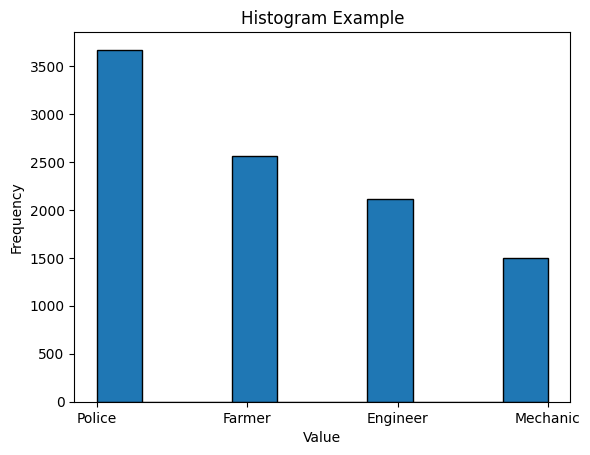

In [174]:
import matplotlib.pyplot as plt

# Sample list of data

# Create a histogram
plt.hist(predictions, bins=10, edgecolor='k')  # 'bins' determines the number of bins or bars

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Show the histogram
plt.show()

In [182]:
i = 0
for i in view2.iter_samples():
    if i.ground_truth.detections[0].label == 'Police'
    print(f'ground_truth1: {i.ground_truth.detections[0].label}')
    print('*****************************')

pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: motorcyclist
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: Police
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
*****************************
pred: Police
ground_truth1: Police
ground_truth2: none
